In [1]:
from sentence_transformers import SentenceTransformer, util

In [2]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [3]:
sentences = ["The weather today is beautiful", "It's raining!", "Dogs are awesome"]
embeddings = model.encode(sentences)
query_embedding = model.encode("today is sunny day!")

for sentence, emb in zip(sentences, embeddings):
    score = util.pytorch_cos_sim(query_embedding, emb)
    print(f"score: {score}", sentence)

score: tensor([[0.6973]]) The weather today is beautiful
score: tensor([[0.5133]]) It's raining!
score: tensor([[0.1889]]) Dogs are awesome


In [4]:
faq = {
    "How do I get a replacement Medicare card?": "If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov.",
    "How do I sign up for Medicare?": "If you already get Social Security benefits, you do not need to sign up for Medicare. We will automatically enroll you in Original Medicare (Part A and Part B) when you become eligible. We will mail you the information a few months before you become eligible.",
    "What are Medicare late enrollment penalties?": "In most cases, if you don’t sign up for Medicare when you’re first eligible, you may have to pay a higher monthly premium. Find more information at https://faq.ssa.gov/en-us/Topic/article/KA-02995",
    "Will my Medicare premiums be higher because of my higher income?": "Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the income-related monthly adjustment amount.",
    "What is Medicare and who can get it?": "Medicare is a health insurance program for people age 65 or older. Some younger people are eligible for Medicare including people with disabilities, permanent kidney failure and amyotrophic lateral sclerosis (Lou Gehrig’s disease or ALS). Medicare helps with the cost of health care, but it does not cover all medical expenses or the cost of most long-term care.",
}

In [5]:
corpus_embeddings = model.encode(list(faq.keys()))
query_emb = model.encode('do i have to pay more after my raise?')
similarities = util.semantic_search(query_emb, corpus_embeddings, top_k=3)

for i, res in enumerate(similarities[0]):
    id, score = res['corpus_id'], res['score']
    query =  list(faq.keys())[id]
    answer = faq[query]
    print(f"score:{score:.2f}, query: {query}, answer: {answer}\n")

score:0.46, query: Will my Medicare premiums be higher because of my higher income?, answer: Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the income-related monthly adjustment amount.

score:0.14, query: What is Medicare and who can get it?, answer: Medicare is a health insurance program for people age 65 or older. Some younger people are eligible for Medicare including people with disabilities, permanent kidney failure and amyotrophic lateral sclerosis (Lou Gehrig’s disease or ALS). Medicare helps with the cost of health care, but it does not cover all medical expenses or the cost of most long-term care.

score:0.13, query: What are Medicare late enrollment penalties?, answer: In most cases, if you don’t sign up for Medicare when you’re first eligible, you may have to pay a higher monthly premium. Find more information at https://faq.ssa.gov/en-us/Topic/artic

In [6]:
from transformers import AutoTokenizer, AutoModel

In [7]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

In [8]:
text = 'The king and the queen are happy.'
tokens = tokenizer.tokenize(text, add_special_tokens=True)
print(tokens)

['[CLS]', 'the', 'king', 'and', 'the', 'queen', 'are', 'happy', '.', '[SEP]']


In [9]:
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
print(output['last_hidden_state'].shape)

torch.Size([1, 10, 768])


In [10]:
king_emb = output['last_hidden_state'][0][2]
queen_emb = output['last_hidden_state'][0][5]
happy_emb = output['last_hidden_state'][0][7]

print(f'similarity (king vs queen): {util.pytorch_cos_sim(king_emb, queen_emb)[0][0]}')
print(f'similarity (king vs happy): {util.pytorch_cos_sim(king_emb, happy_emb)[0][0]}')

similarity (king vs queen): 0.7920710444450378
similarity (king vs happy): 0.5239198207855225


In [11]:
text = "The angry and unhappy king"
encoded_input = tokenizer(text, return_tensors='pt')
output  = model(**encoded_input)
print(output['last_hidden_state'].shape)

torch.Size([1, 7, 768])


In [12]:
tokenizer.tokenize(text, add_special_tokens=True)

['[CLS]', 'the', 'angry', 'and', 'unhappy', 'king', '[SEP]']

In [13]:
king2_emb = output['last_hidden_state'][0][5]
print(f'similarity (king1 vs king2): {util.pytorch_cos_sim(king_emb, king2_emb)[0][0]}')

similarity (king1 vs king2): 0.574000895023346


In [14]:
print(tokenizer.tokenize('tokenization'))

['token', '##ization']


In [15]:
text ="""
<html>
</html>
"""
tokenizer.tokenize(text, add_special_tokens=True)

['[CLS]', '<', 'html', '>', '<', '/', 'html', '>', '[SEP]']

In [16]:
text = 'this is about tokenization'
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [17]:
tokenizer.tokenize(text, add_special_tokens=True)

['[CLS]', 'this', 'is', 'about', 'token', '##ization', '[SEP]']

In [18]:
word_token_indices = [4, 5]
word_embeddings = output['last_hidden_state'][0, word_token_indices]
word_embeddings.shape

torch.Size([2, 768])

In [19]:
import torch
word_embeddings = torch.mean(word_embeddings, dim=0)

In [20]:
tokenizer.encode(text, add_special_tokens=False)

[2023, 2003, 2055, 19204, 3989]

In [21]:
tokenizer.encode('tokenization', add_special_tokens=False)

[19204, 3989]

In [22]:
def get_word_embedding(text, word):
    encoded_input = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        output = model(**encoded_input)
    word_ids = tokenizer.encode(word, add_special_tokens=False)
    word_indices = [i for i, token_id in enumerate(encoded_input['input_ids'][0]) if token_id in word_ids]
    word_embeddings = output['last_hidden_state'][0, word_indices]
    return torch.mean(word_embeddings, dim=0)

In [23]:
word_embeddings2 = get_word_embedding(text, 'tokenization')
print(word_embeddings2.shape)
print(torch.allclose(word_embeddings, word_embeddings2))

torch.Size([768])
True


In [24]:
util.pytorch_cos_sim(
    get_word_embedding('the king is angry', 'king'),
    get_word_embedding('the queen is angry', 'queen')
)

tensor([[0.8564]])

In [25]:
util.pytorch_cos_sim(
    get_word_embedding('the king is angry', 'king'),
    get_word_embedding('the queen is happy', 'queen')
)

tensor([[0.8059]])

In [26]:
encoded_input = tokenizer("this is an example sentence", return_tensors='pt')
output = model(**encoded_input)
cls_embedding = output['last_hidden_state'][:, 0, :]
sentence_embedding = cls_embedding
print(sentence_embedding.shape)

torch.Size([1, 768])


In [27]:
def cls_pooling(model_output):
    return model_output['last_hidden_state'][:, 0, :]

def get_sentence_embedding(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        output = model(**encoded_input)
    return cls_pooling(output)

In [28]:
print(get_sentence_embedding('this is an example sentence').shape)

torch.Size([1, 768])


In [29]:
embeddings = [get_sentence_embedding(sentence) for sentence in sentences]
query_embedding = get_sentence_embedding("today is sunny day")
for sentence, embedding in zip(sentences, embeddings):
    score = util.pytorch_cos_sim(query_embedding, embedding)
    print(f"{score}: {sentence}")

tensor([[0.9317]]): The weather today is beautiful
tensor([[0.8939]]): It's raining!
tensor([[0.9162]]): Dogs are awesome


In [30]:
def cls_pooling(model_output):
    return model.pooler(model_output['last_hidden_state'])

embeddings = [get_sentence_embedding(sentence) for sentence in sentences]
query_embedding = get_sentence_embedding("today is sunny day")
for sentence, embedding in zip(sentences, embeddings):
    score = util.pytorch_cos_sim(query_embedding, embedding)
    print(f"{score}: {sentence}")

tensor([[0.9759]], grad_fn=<MmBackward0>): The weather today is beautiful
tensor([[0.9329]], grad_fn=<MmBackward0>): It's raining!
tensor([[0.8674]], grad_fn=<MmBackward0>): Dogs are awesome


In [31]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [32]:
encoded_input = tokenizer("today is a sunny day", return_tensors='pt')
model_output = model(**encoded_input)

In [33]:
token_embeddings = model_output['last_hidden_state']
print(token_embeddings.shape)
mean_embeddings = torch.mean(token_embeddings, dim=1)
print(mean_embeddings.shape)

torch.Size([1, 7, 384])
torch.Size([1, 384])


In [34]:
import torch.nn.functional as F

def mean_pooling(model_output):
    return torch.mean(model_output['last_hidden_state'], dim=1)

def get_sentence_embedding(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    meam_embeddings = mean_pooling(model_output)
    return F.normalize(mean_embeddings)

In [35]:
get_sentence_embedding('today is a sunny day').shape

torch.Size([1, 384])

In [36]:
print(token_embeddings.shape)
attention_mask = encoded_input['attention_mask']
print(attention_mask.shape)
attention_mask_expanded = (
    attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
)
print(attention_mask_expanded.shape)

torch.Size([1, 7, 384])
torch.Size([1, 7])
torch.Size([1, 7, 384])


In [37]:
print(attention_mask_expanded.sum(1).shape)
print(token_embeddings.sum(1).shape)

torch.Size([1, 384])
torch.Size([1, 384])


In [38]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output['last_hidden_state']
    attention_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return token_embeddings.sum(1)/torch.clamp_min(attention_mask_expanded.sum(1), min=1e-9)

def get_sentence_embedding(text):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        model_output = model(**encoded_input)
    attention_mask = encoded_input['attention_mask']
    sentence_embeddings = mean_pooling(model_output, attention_mask)
    return F.normalize(sentence_embeddings)

In [39]:
query_embedding = get_sentence_embedding("today is a sunny day")[0]
query_embedding[:5]

tensor([-0.0163,  0.1041,  0.0974,  0.0742,  0.0375])

In [40]:
embeddings = [get_sentence_embedding(sentence) for sentence in sentences]
query_embedding = get_sentence_embedding("today is sunny day")
for sentence, embedding in zip(sentences, embeddings):
    score = util.pytorch_cos_sim(query_embedding, embedding)
    print(f"{score}: {sentence}")

tensor([[0.7190]]): The weather today is beautiful
tensor([[0.3898]]): It's raining!
tensor([[0.1043]]): Dogs are awesome


In [41]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
query_embedding = model.encode('today is a sunny day')
embeddings = model.encode(sentences)
for sentence, embedding in zip(sentences, embeddings):
    score = util.pytorch_cos_sim(query_embedding, embedding)
    print(f"{score}: {sentence}")

tensor([[0.7344]]): The weather today is beautiful
tensor([[0.4180]]): It's raining!
tensor([[0.1060]]): Dogs are awesome


In [42]:
# !pip install datasets

In [43]:
from datasets import load_dataset

In [44]:
dataset = load_dataset('quora')['train']
dataset

Dataset({
    features: ['questions', 'is_duplicate'],
    num_rows: 404290
})

In [45]:
corpus_questions = []
for d in dataset:
    corpus_questions.append(d['questions']['text'][0])
    corpus_questions.append(d['questions']['text'][1])
corpus_questions = list(set(corpus_questions))
print(len(corpus_questions))

537362


In [46]:
model = SentenceTransformer('quora-distilbert-multilingual')
question_to_emb = 100000
corpus_embeddings = model.encode(
    corpus_questions[:question_to_emb],
    show_progress_bar=True,
    convert_to_tensor=True
)

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

In [47]:
import time

def search(query):
    s_t = time.time()
    query_emb = model.encode(query, convert_to_tensor=True)
    res = util.semantic_search(query_emb, corpus_embeddings)
    e_t = time.time()
    print(f'time taken: {e_t-s_t:.3f}')
    for result in res[0][:5]:
        print(f"score:{result['score']} ({corpus_questions[result['corpus_id']]})")

In [48]:
search('how can i learn Machine Learning online')

time taken: 0.020
score:0.9535212516784668 (How do I apply machine learning in business?)
score:0.9479966163635254 (How should I get started with Machine Learning?)
score:0.9441681504249573 (How can I teach myself machine learning?)
score:0.9439151287078857 (How do I start machine learning?)
score:0.9413508176803589 (I am a beginner to Machine Learning? Can you tell me the best and perfect way to learn Machine Learning? )


In [49]:
search('Como puedo aprender Machine Learning online?')

time taken: 0.012
score:0.9583358764648438 (How do I apply machine learning in business?)
score:0.9560607075691223 (How should I get started with Machine Learning?)
score:0.9519637227058411 (How do I start machine learning?)
score:0.9497790336608887 (How can I teach myself machine learning?)
score:0.9489298462867737 (I am a beginner to Machine Learning? Can you tell me the best and perfect way to learn Machine Learning? )


In [54]:
questions_to_emb = 10
short_corpus_questions = corpus_questions[:questions_to_emb]
short_corpus_questions

['Would this be a painful way to die?',
 '',
 'What is the best definition of Nowtopia?',
 "I'm a 16yo girl. My height is 5 feet 6.5 inches. How can I grow 2-3 inches taller within a month or two naturally?",
 'Me in my crush always get shy around each other why is that?',
 'Which branch of engineering is the most useful?',
 'What universities does EMC insurance Group recruit new grads from? What majors are they looking for?',
 'How do I find a densest subgraph using a parametric network flow algorithm?',
 'What is the function of the cytoplasm in an animal cell? How is it important?',
 'What are the top 5 Martial Arts?']

In [56]:
model = SentenceTransformer('quora-distilbert-multilingual')
embeddings = model.encode(short_corpus_questions)
embeddings.shape

(10, 768)

In [72]:
s_t = time.time()
similarity = util.pytorch_cos_sim(embeddings, embeddings)
e_t = time.time()
print(f"time taken:{e_t-s_t:.3f} seconds")
print(similarity.shape)
similarity


time taken:0.001 seconds
torch.Size([10, 10])


tensor([[1.0000, 0.6886, 0.7211, 0.8047, 0.7392, 0.6964, 0.7148, 0.7130, 0.7471,
         0.7925],
        [0.6886, 1.0000, 0.7810, 0.7729, 0.6691, 0.6928, 0.6653, 0.7287, 0.6900,
         0.7115],
        [0.7211, 0.7810, 1.0000, 0.8204, 0.7339, 0.7765, 0.7675, 0.8313, 0.8244,
         0.7684],
        [0.8047, 0.7729, 0.8204, 1.0000, 0.8002, 0.7288, 0.7869, 0.8247, 0.7720,
         0.8289],
        [0.7392, 0.6691, 0.7339, 0.8002, 1.0000, 0.6619, 0.7025, 0.7887, 0.7361,
         0.6945],
        [0.6964, 0.6928, 0.7765, 0.7288, 0.6619, 1.0000, 0.7638, 0.7195, 0.7740,
         0.7617],
        [0.7148, 0.6653, 0.7675, 0.7869, 0.7025, 0.7638, 1.0000, 0.7877, 0.7272,
         0.7358],
        [0.7130, 0.7287, 0.8313, 0.8247, 0.7887, 0.7195, 0.7877, 1.0000, 0.7936,
         0.7422],
        [0.7471, 0.6900, 0.8244, 0.7720, 0.7361, 0.7740, 0.7272, 0.7936, 1.0000,
         0.7460],
        [0.7925, 0.7115, 0.7684, 0.8289, 0.6945, 0.7617, 0.7358, 0.7422, 0.7460,
         1.0000]])

In [64]:
def compute_embeddings_slow(questions, n=10):
    embeddings = model.encode(questions[:n], show_progress_bar=True, convert_to_tensor=True)
    s_t = time.time()
    distance = util.pytorch_cos_sim(embeddings, embeddings)
    e_t = time.time()
    return distance, e_t-s_t

compute_embeddings_slow(corpus_questions)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(tensor([[1.0000, 0.6886, 0.7211, 0.8047, 0.7392, 0.6964, 0.7148, 0.7130, 0.7471,
          0.7925],
         [0.6886, 1.0000, 0.7810, 0.7729, 0.6691, 0.6928, 0.6653, 0.7287, 0.6900,
          0.7115],
         [0.7211, 0.7810, 1.0000, 0.8204, 0.7339, 0.7765, 0.7675, 0.8313, 0.8244,
          0.7684],
         [0.8047, 0.7729, 0.8204, 1.0000, 0.8002, 0.7288, 0.7869, 0.8247, 0.7720,
          0.8289],
         [0.7392, 0.6691, 0.7339, 0.8002, 1.0000, 0.6619, 0.7025, 0.7887, 0.7361,
          0.6945],
         [0.6964, 0.6928, 0.7765, 0.7288, 0.6619, 1.0000, 0.7638, 0.7195, 0.7740,
          0.7617],
         [0.7148, 0.6653, 0.7675, 0.7869, 0.7025, 0.7638, 1.0000, 0.7877, 0.7272,
          0.7358],
         [0.7130, 0.7287, 0.8313, 0.8247, 0.7887, 0.7195, 0.7877, 1.0000, 0.7936,
          0.7422],
         [0.7471, 0.6900, 0.8244, 0.7720, 0.7361, 0.7740, 0.7272, 0.7936, 1.0000,
          0.7460],
         [0.7925, 0.7115, 0.7684, 0.8289, 0.6945, 0.7617, 0.7358, 0.7422, 0.7460,
         

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/626 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

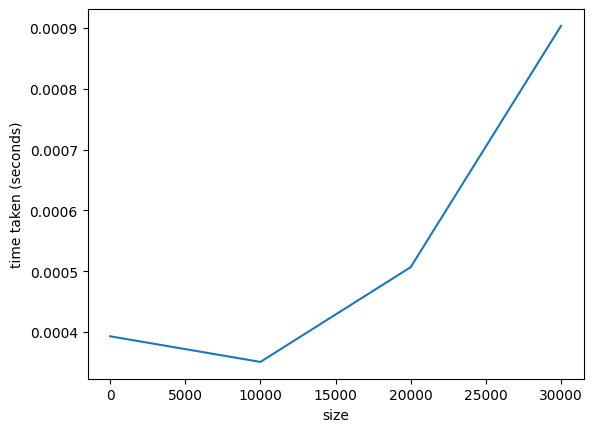

In [67]:
import matplotlib.pyplot as plt

sizes = [1, 10001, 20001, 30001]
times = []

for n in sizes:
    _, time_taken = compute_embeddings_slow(corpus_questions, n=n)
    times.append(time_taken)
    torch.cuda.empty_cache()

plt.plot(sizes, times);
plt.xlabel('size')
plt.ylabel('time taken (seconds)');

In [69]:
s_t = time.time()
paraphrases = util.paraphrase_mining(model, corpus_questions[:100000], show_progress_bar=True)
e_t = time.time()

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

In [79]:
for n in [2, 3, 10, 100000]:
    print(n, '->', (n*(n-1))/2)

2 -> 1.0
3 -> 3.0
10 -> 45.0
100000 -> 4999950000.0


In [70]:
len(paraphrases)

251054

In [71]:
paraphrases[:5]

[[1.0000005960464478, 1215, 78173],
 [1.0000005960464478, 42521, 56745],
 [1.000000238418579, 34916, 90316],
 [1.0000001192092896, 55852, 96873],
 [0.9999998211860657, 6296, 87628]]

In [75]:
for score, i, j in paraphrases[:5]:
    print(f"score: {score}, 1. {corpus_questions[i]}; 2. {corpus_questions[j]}\n")

score: 1.0000005960464478, 1. How do I overcome my inferiority complex ?; 2. How do I overcome my inferiority complex?

score: 1.0000005960464478, 1. How does ngrok work ?; 2. How does ngrok work?

score: 1.000000238418579, 1. What are some good YouTube channels to study inorganic chemistry for IIT JEE?; 2. What are some good YouTube channels to study inorganic chemistry for IIT JEE ?

score: 1.0000001192092896, 1. What are the skills required for big data jobs?; 2. What are the skills required for big data jobs?  

score: 0.9999998211860657, 1. What ethnicity do I look like?; 2. What ethnicity do I look like ?



In [83]:
# defaults of paraphrase mining
query_chunk_size = 5000
corpus_chunk_size = 100000
top_k = 100